In [17]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist, squareform
from scipy.stats import invgamma
from geopy.distance import geodesic
from dms_variants.ispline import Isplines, Isplines_total
from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize
from sklearn.preprocessing import PolynomialFeatures
import pymc as pm
import sys

# Check data loading

Errors caught:

None

In [18]:
#----------------------------------------------------------------
# load in and parse data
#----------------------------------------------------------------

# dat_all = pd.read_csv("../../data/sa_family_data.csv").sample(n=20,random_state=1)
dat_all = pd.read_csv("../../data/sa_family_data.csv").sample(n=50,random_state=1)

# Parse data into location, environmental variables, and species cover/presence
location_mat = dat_all[['latitude', 'longitude']].values
env_var_names = ['gmap', 'RFL_CONC', 'Elevation30m', 'HeatLoadIndex30m', 'tmean13c', 'SoilConductivitymSm', 'SoilTotalNPercent']
envr_use = dat_all[['gmap', 'RFL_CONC', 'Elevation30m', 'HeatLoadIndex30m', 'tmean13c', 'SoilConductivitymSm', 'SoilTotalNPercent']].values
species_mat = dat_all.iloc[:, 12:].values

location_mat_R = pd.read_csv("CSV-comparisons/location_mat_R.csv")
envr_use_R = pd.read_csv("CSV-comparisons/envr_use_R.csv")
species_mat_R = pd.read_csv("CSV-comparisons/species_mat_R.csv")


In [19]:
# Check if the location_mat variable is equal to the latitude and longitude columns of location_mat_R
location_check = np.all(location_mat == location_mat_R[['latitude', 'longitude']].values)
print(f"Location matrix check: {location_check}")
# Explanation: This checks if the location_mat variable is equal to the latitude and longitude columns of location_mat_R. It returns True if they are equal, and False otherwise.

# Check if the envr_use variable is equal to the values of envr_use_R
envr_use_check = np.all(envr_use == envr_use_R.values)
print(f"Environmental use matrix check: {envr_use_check}")
# Explanation: This checks if the envr_use variable is equal to the values of envr_use_R. It returns True if they are equal, and False otherwise.

# Check if the species_mat variable is equal to the values of species_mat_R
species_mat_check = np.all(species_mat == species_mat_R.values)
print(f"Species matrix check: {species_mat_check}")
# Explanation: This checks if the species_mat variable is equal to the values of species_mat_R. It returns True if they are equal, and False otherwise.

Location matrix check: False
Environmental use matrix check: False
Species matrix check: False


# Check pairwise-distance calculation:

Errors caught:
- R code obtained the flattened Z vector from upper.triangular. Python uses the lower.triangular by default. Switched R code to lower.triangular.

In [20]:
# Get the number of sites
ns = location_mat.shape[0]

#----------------------------------------------------------------
# Calculate Bray-Curtis dissimilarity -- see proportion of 0's and 1's
#----------------------------------------------------------------

# Define dissimilarity metric
diss_met = 'braycurtis'

# Create pair-wise response matrix. pdist outputs a 1D matrix
Z = pdist(species_mat, diss_met)

# Find indices for observations with dissimilarity of exactly 1
Z_is_one = np.where(Z == 1)[0]
Z_is_not_one = np.where(Z != 1)[0]

# Get counts
n1 = len(Z_is_one)
N = len(Z)

# Print the proportion of zeros and ones in the diinternal_knots = knots(I_splines_x)ssimilarity matrix
print(f"Proportion of zeros: {np.mean(Z == 0)}")
print(f"Proportion of ones: {np.mean(Z == 1)}")

Proportion of zeros: 0.0
Proportion of ones: 0.04653061224489796


In [21]:
Z_R = pd.read_csv("CSV-comparisons/Z_R.csv")

# Check if the Z variable is equal to the values of Z_R
Z_check = np.allclose(Z, Z_R.values.reshape(-1), atol=1e-5)
print(f"Dissimilarity matrix check: {Z_check}")
# Explanation: This checks if the Z variable is equal to the values of Z_R. It returns True if they are equal, and False otherwise.

Dissimilarity matrix check: False


# Check for errors in generating the I-splines

Errors caught:

 - Degrees, knots and df were mispecified in either the R or python code. Likely the python code. TODO: Double check understanding

In [22]:
#----------------------------------------------------------------
# Define covariates that will be warped by I-spline function AND coefficients
#----------------------------------------------------------------

# Calculate pairwise geographical distance in km using geodesic with WGS84 in vector form (upper triangle of matrix)
vec_distance = pdist(location_mat, lambda lat, lon: geodesic(lat, lon).kilometers)

# Define a (sub)set of environmental variables to be used as covariates
X = envr_use[:, [0, 1, 2, 3, 4, 5, 6]]

# How many knots do you want? What is the degree of the spline?
# Remember that in the specification, of the iSpline that the degree is
# one higher that what you say. Integration of m-spline adds one degree.
# Define the degree and number of knots for the I-spline basis
deg = 3
knots = 2
order = deg + 1
df = deg + knots

# TODO - Double check understanding of the order and degrees. Previously I used the order in the ISpline function call.

# Create ISpline bases, with different range (i.e. mesh) for each variable. Note NO extrapolation with this method, only interpolation.
I_spline_bases = np.column_stack([
    Isplines(deg, [X[:,i].min(), X[:,i].min() + (X[:,i].max() - X[:,i].min())/3, X[:,i].min() + (X[:,i].max() - X[:,i].min())*2/3, X[:,i].max()], X[:,i]).I(j) 
    for i in range(X.shape[1]) 
    for j in range(1,df+1)])

# Pairwise differences of each basis function in a vector. Shape ns**2 / 2 x p * df
I_spline_bases_diffs = np.array([pdist(I_spline_bases[:, i].reshape(-1, 1), metric='euclidean') for i in range(I_spline_bases.shape[1])]).T

# Create spline for the geodesic distances
dist_mesh = [vec_distance.min(), vec_distance.min() + (vec_distance.max() - vec_distance.min())/3, vec_distance.min() + (vec_distance.max() - vec_distance.min())*2/3, vec_distance.max()]
dist_splines = np.column_stack([Isplines(deg, dist_mesh, vec_distance).I(i) for i in range(1, df+1)])

# Combine the I-spline bases and the geographical distances
X_GDM = np.column_stack([I_spline_bases_diffs, dist_splines])

# Name columns
column_names = [f"{var}_I{j}" for var in env_var_names for j in range(1, df+1)] + [f"Dist_I{j}" for j in range(1, df+1)]
X_GDM_df = pd.DataFrame(X_GDM, columns=column_names)
p = X_GDM.shape[1]

# Get row and column indices for each dissimilarity 
row_ind, col_ind = np.triu_indices(ns, k=1)

## Test splines with linearly generated data

Produced splines are identical.

x check: True
I_splines_x check: True


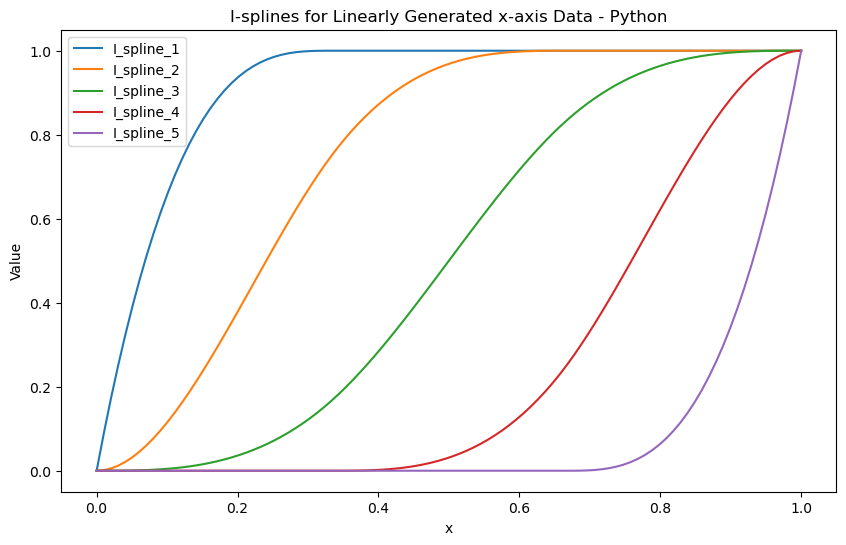

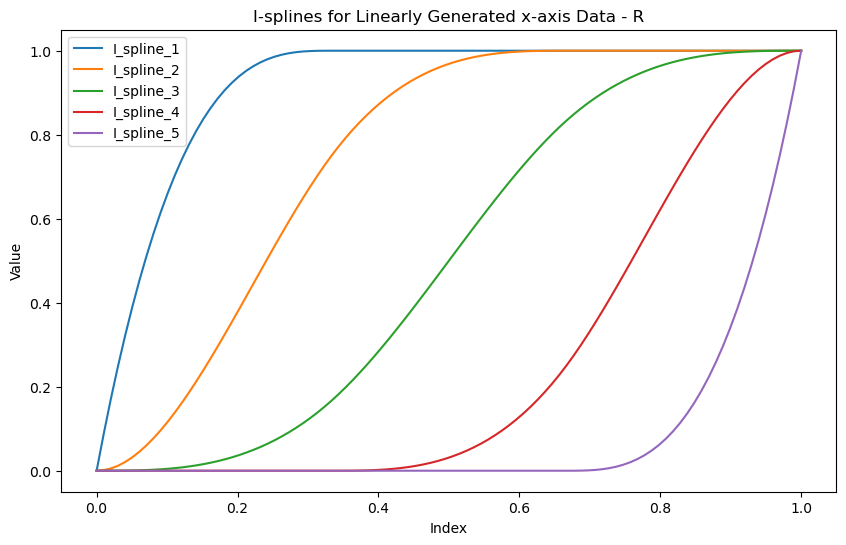

In [23]:
import pandas as pd

# Plotting the I-splines for linearly generated x-axis data
x = np.linspace(0, 1, 100)

deg = 3
knots = 2
order = deg + 1
df = deg + knots

I_splines_x = np.column_stack([Isplines(deg, [x.min(), x.min() + (x.max() - x.min())/3, x.min() + (x.max() - x.min())*2/3, x.max()], x).I(j) for j in range(1,df+1)])
I_splines_x_R = pd.read_csv("CSV-comparisons/I_splines_x_R.csv")

import matplotlib.pyplot as plt

# Check if inputs are the same: x and x_R
x_R = pd.read_csv("CSV-comparisons/x_R.csv")
x_check = np.allclose(x, x_R.values.reshape(-1))
print(f"x check: {x_check}")

# Check if output is the same: I_splines_x is equal to I_splines_x_R
I_splines_x_check = np.allclose(I_splines_x, I_splines_x_R.values, atol=1e-5)
print(f"I_splines_x check: {I_splines_x_check}")

# Plot the I-splines for linearly generated x-axis data - Python
plt.figure(figsize=(10, 6))
for i in range(I_splines_x.shape[1]):
    plt.plot(x, I_splines_x[:, i], label=f'I_spline_{i+1}')
plt.xlabel('x')
plt.ylabel('Value')
plt.legend()
plt.title('I-splines for Linearly Generated x-axis Data - Python')
plt.show()

# For R
plt.figure(figsize=(10, 6))
for i in range(I_splines_x_R.shape[1]):
    plt.plot(x, I_splines_x_R.values[:, i], label=f'I_spline_{i+1}')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.title('I-splines for Linearly Generated x-axis Data - R')
plt.show()

# I_splines_x_df = pd.DataFrame(I_splines_x, columns=[f"iSpline(x, degree = 2, df = 5, intercept = TRUE){i+1}" for i in range(df)])
# print(I_splines_x_df.describe())
# I_splines_x_R.describe()

## Compare dist I Spline bases

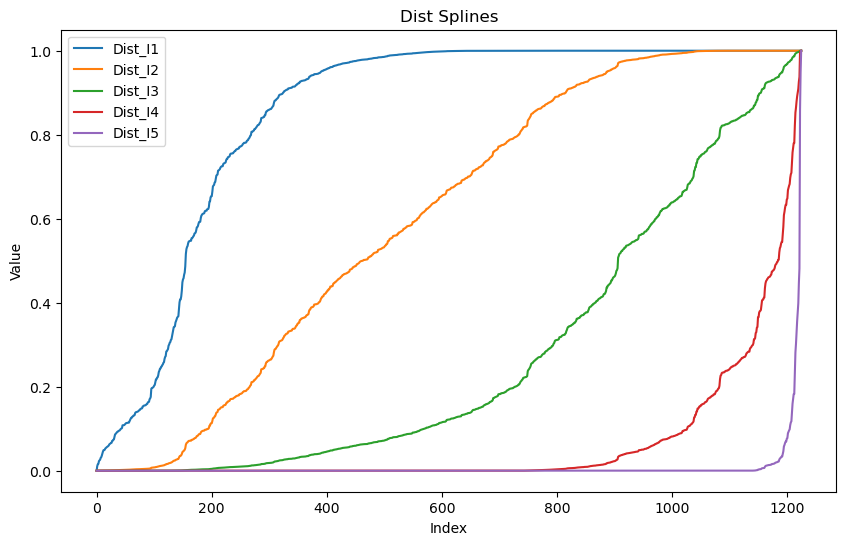

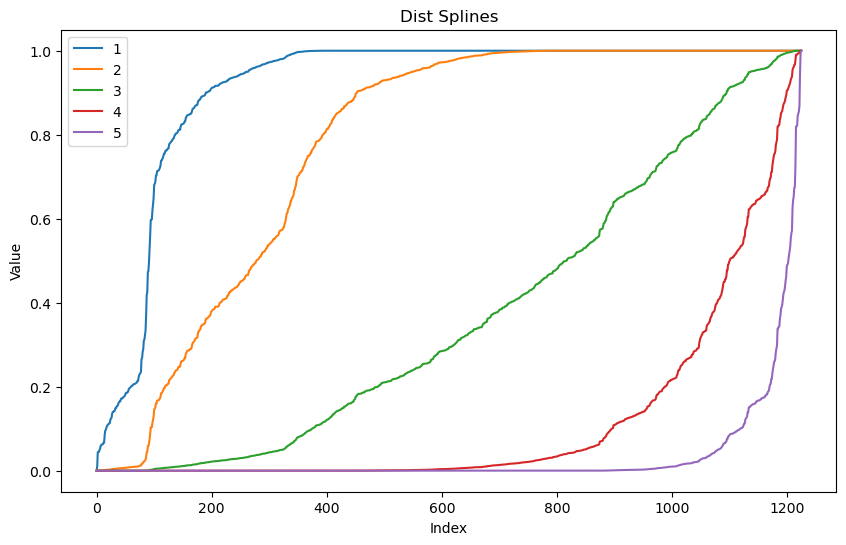

In [24]:
# TODO: Check the bases are the same. They should be almost identical.

X_R = pd.read_csv("CSV-comparisons/X_R.csv")

np.all(X == X_R)

dist_splines_R = pd.read_csv("CSV-comparisons/dist_splines_R.csv")

dist_splines_df = pd.DataFrame(dist_splines, columns=[f"Dist_I{j}" for j in range(1, df+1)])

# Plot the data
plt.figure(figsize=(10, 6))
for column in dist_splines_df.columns:
    sorted_values = np.sort(dist_splines_df[column])
    plt.plot(range(len(sorted_values)), sorted_values, label=column)
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.title('Dist Splines')
plt.show()

# Plot the data
plt.figure(figsize=(10, 6))
for column in dist_splines_R.columns:
    sorted_values = np.sort(dist_splines_R[column])
    plt.plot(range(len(sorted_values)), sorted_values, label=column)
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.title('Dist Splines')
plt.show()

## Compare inputs to basis functions

Inputs are identical

In [25]:
vec_distance_R = pd.read_csv("CSV-comparisons/vec_distance_R.csv")

# Check if vec_distance is equal to vec_distance_R
vec_distance_check = np.allclose(vec_distance, vec_distance_R.values.reshape(-1), atol=1e-5)
print(f"vec_distance check: {vec_distance_check}")

I_spline_bases_R = pd.read_csv("CSV-comparisons/I_spline_bases_R.csv")
X_GDM_R = pd.read_csv("CSV-comparisons/X_GDM_R.csv")

# Check if I_spline_bases is equal to I_spline_bases_R
I_spline_bases_check = np.allclose(I_spline_bases, I_spline_bases_R.values, atol=1e-5)
print(f"I_spline_bases check: {I_spline_bases_check}")

vec_distance check: False
I_spline_bases check: False


In [26]:
import pandas as pd

X_R = pd.read_csv("CSV-comparisons/X_R.csv")

# Inputs to python I spline bases
# X but this is confirmed equal to X_R
print(np.all(X == X_R))
# Spline creation function. deg = 3, df + 1 = 6
# Confirmed equal production from x linearly spaced from 0 to 1

# Inputs to R I spline bases
# X_R confirmed equal to X
# Created

X_df = pd.DataFrame(X, columns=[f"Feature_{i+1}" for i in range(X.shape[1])])
print(X_df.describe())
print("--------------------\n")
print(X_R.describe())

# I believe it is a problem with the R implementation of the I-splines. The values are not the same as the Python implementation. Maybe something to do with how it figures out the boundary notes etc

False
        Feature_1  Feature_2    Feature_3   Feature_4  Feature_5  Feature_6  \
count   50.000000     50.000    50.000000   50.000000  50.000000  50.000000   
mean   223.860000     30.582   956.720000  210.760000  16.396000  35.445159   
std     45.326935      9.876   389.612735   12.100869   2.087862  19.412408   
min     90.000000     15.300   188.000000  159.000000  12.400000   5.049379   
25%    206.500000     24.000   720.000000  207.250000  14.950000  22.483001   
50%    219.000000     30.100  1051.500000  215.000000  16.200001  30.673420   
75%    232.750000     35.275  1209.000000  217.000000  17.299999  49.073657   
max    387.000000     51.500  1620.000000  236.000000  20.000000  85.029121   

       Feature_7  
count  50.000000  
mean    0.106492  
std     0.047432  
min     0.037979  
25%     0.075589  
50%     0.093034  
75%     0.117239  
max     0.242568  
--------------------

             gmap   RFL_CONC  Elevation30m  HeatLoadIndex30m   tmean13c  \
count   50.000

##  Plotting the I_Spline bases matrices for python and R

The I Spline Bases produced are not identical. The R code seems to be putting knots NOT at 33% and 66%. I don't know why, and I don't know if it's better. Hence they are different. Moreover, I don't know if it matters - if we are going to train parameters on these anyway, will this become irrelevant anyway? I would guess probably not, seeing as there will be more flexibility with the R code (internal knots are very central).

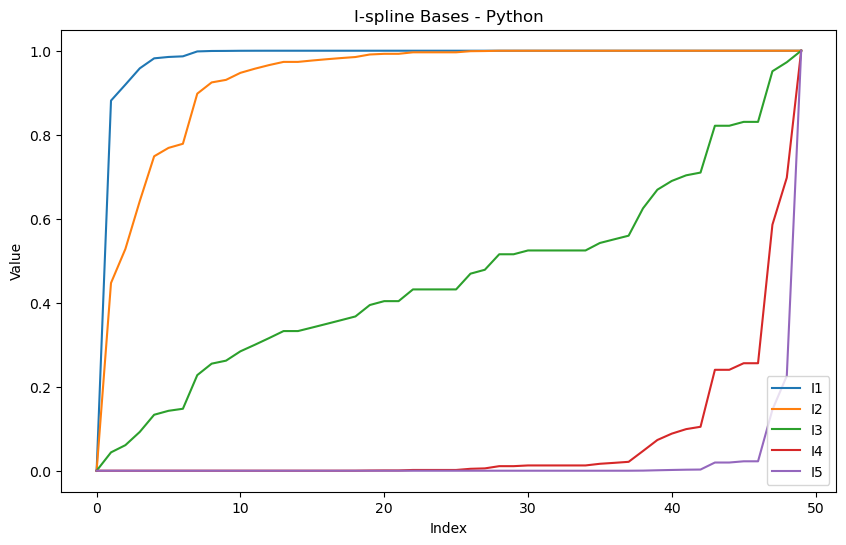

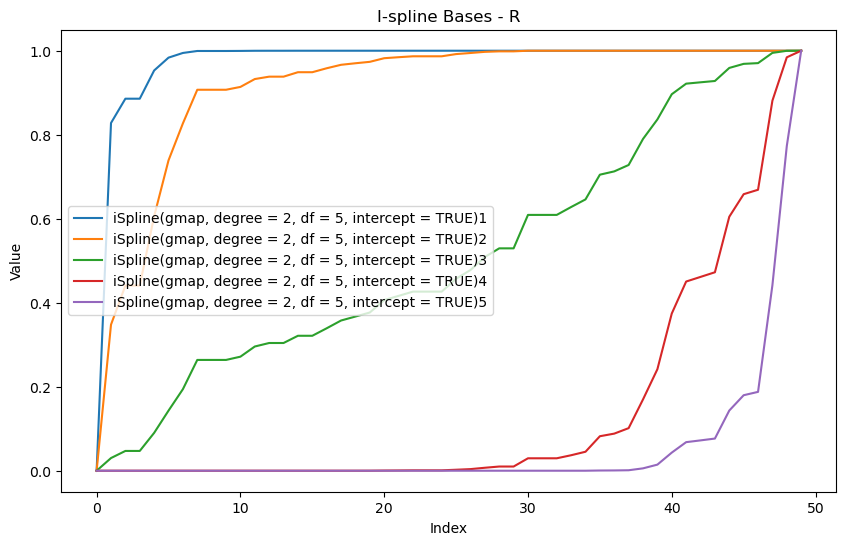

Check modified I-spline bases are the same: 
False


In [27]:
# Testing the base on the first column with internal knot boundaries as in the R code. I.e. at 208 and 231.
x = X[:,0]
I_splines_base_test = np.column_stack([Isplines(deg, [x.min(), 208, 231, x.max()], x).I(j) for j in range(1,df+1)])

# Select the columns to plot
# Convert the numpy.ndarray to a pandas DataFrame
I_spline_bases_test_df = pd.DataFrame(I_splines_base_test, columns=[f"I{j}" for j in range(1, df+1)])

# Select the columns to plot
columns_to_plot = I_spline_bases_test_df.columns[:5]

# Plot the data
plt.figure(figsize=(10, 6))
for column in columns_to_plot:
    sorted_values = np.sort(I_spline_bases_test_df[column])
    plt.plot(range(len(sorted_values)), sorted_values, label=column)
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.title('I-spline Bases - Python')
plt.show()

# Select the columns to plot
columns_to_plot = I_spline_bases_R.columns[:5]

# Plot the data
plt.figure(figsize=(10, 6))
for column in columns_to_plot:
    sorted_values = np.sort(I_spline_bases_R[column])
    plt.plot(range(len(sorted_values)), sorted_values, label=column)
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.title('I-spline Bases - R')
plt.show()

print("Check modified I-spline bases are the same: ")
print(np.allclose(I_splines_base_test, I_spline_bases_R.values[:,:5], atol=1e-5))

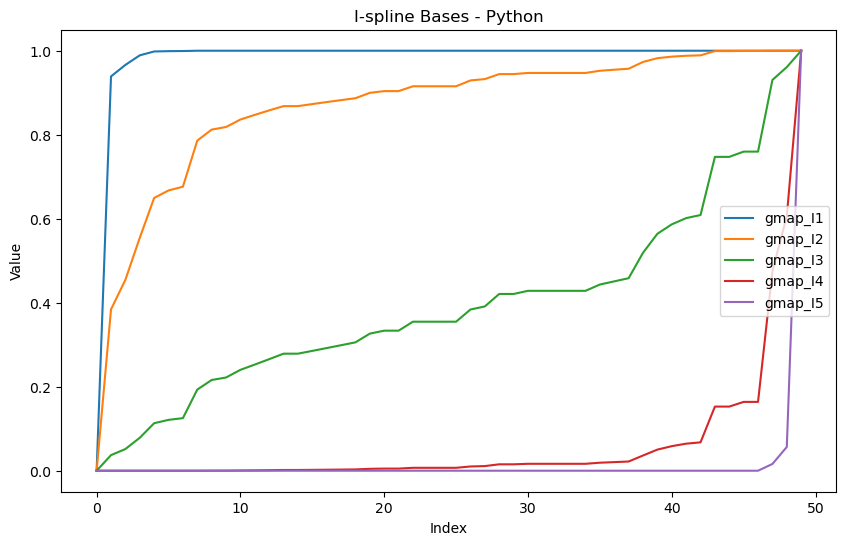

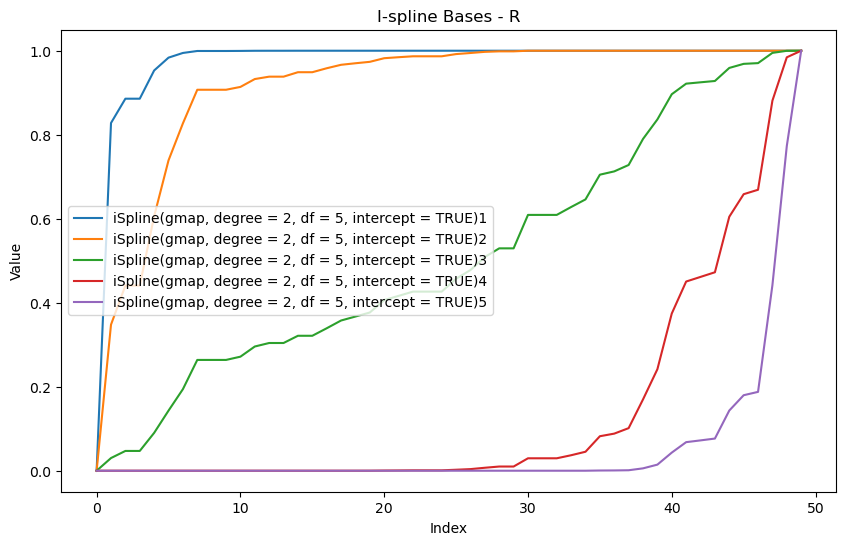

In [28]:
import matplotlib.pyplot as plt

# Select the columns to plot
# Convert the numpy.ndarray to a pandas DataFrame
I_spline_bases_df = pd.DataFrame(I_spline_bases, columns=[f"{var}_I{j}" for var in env_var_names for j in range(1, df+1)])

# Select the columns to plot
columns_to_plot = I_spline_bases_df.columns[:5]

# Plot the data
plt.figure(figsize=(10, 6))
for column in columns_to_plot:
    sorted_values = np.sort(I_spline_bases_df[column])
    plt.plot(range(len(sorted_values)), sorted_values, label=column)
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.title('I-spline Bases - Python')
plt.show()

I_spline_bases_R = pd.read_csv("CSV-comparisons/I_spline_bases_R.csv")

# Select the columns to plot
columns_to_plot = I_spline_bases_R.columns[:5]

# Plot the data
plt.figure(figsize=(10, 6))
for column in columns_to_plot:
    sorted_values = np.sort(I_spline_bases_R[column])
    plt.plot(range(len(sorted_values)), sorted_values, label=column)
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.title('I-spline Bases - R')
plt.show()


# TODO
- Visualise the effect of the R and Python differences in the X_GDM output

# Check initial modelling set-up

## TODO:
- Check what the adding of random values does to the initial parameters. It seems to make the optimisation more stable, but is that a side effect - why do we add them?

In [63]:
from multiprocessing import Pool

#------------------------------------------------------------------------
# Get initial values to speed up spGDMM fitting
#------------------------------------------------------------------------

# Fit linear model
lm_mod = LinearRegression(fit_intercept=True).fit(X_GDM, np.log(Z))

# Define objective function
objective = lambda params: np.sum((np.log(Z) - params[0] - X_GDM @ np.exp(params[1:(p+1)]))**2)

# Set up initial parameters, taking logs of positive and setting negative coefficients to -10
# Suppress the warning only for this block where log of negative values may occur during RunTime
with np.errstate(invalid='ignore'):
    initial_params = np.concatenate([
        [0.3],  # Intercept, this is an initial guess for the model
        np.where(lm_mod.coef_ > 0, np.log(lm_mod.coef_), -10),  # Log coefficients greater than 0, set others to -10
        np.random.randn(ns)  # Random values for each site (if needed)
    ])

def parallel_minimize(params):
    return minimize(objective, params, method='BFGS', options={'disp': True})

# Create a pool of workers
with Pool() as pool:
    # Run the optimization in parallel
    lm_out = pool.apply(parallel_minimize, (initial_params,))

optimised_params = lm_out.x
optimised_value = lm_out.fun
optimised_counts = np.array([lm_out.nfev, lm_out.njev])

# Compare positions of coefficients that are negative with positions in initial_params that are -10
negative_coeff_positions = np.where(lm_mod.coef_ < 0)[0]
initial_params_negative_positions = np.where(initial_params == -10)[0]

print(np.all((negative_coeff_positions + 1) == initial_params_negative_positions))
# if not lm_out.success:
#     raise ValueError("Optimization did not converge successfully: ", lm_out.message)

/home/harold/miniconda3/envs/spGDMM/lib/python3.12/site-packages/scipy/optimize/_minimize.py:726: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 118.007006
         Iterations: 266
         Function evaluations: 33028
         Gradient evaluations: 359
True


In [64]:
print(optimised_counts)
print(optimised_counts_R)

[33028   359]
     x
0  152
1  100


In [67]:
# Comparing to optimisation in R
optimised_params_R = pd.read_csv("CSV-comparisons/optimised_params_R.csv")
optimised_value_R = pd.read_csv("CSV-comparisons/optimised_value_R.csv")
optimised_counts_R = pd.read_csv("CSV-comparisons/optimised_counts_R.csv")

# Put two optimisations side by side in the same dataframe
# Create separate dataframes for each comparison since they have different row numbers
optimised_params_df = pd.DataFrame({
    'Python-params': optimised_params,
    'R-params': optimised_params_R.values.reshape(-1)
})

optimised_value_df = pd.DataFrame({
    'Python-value': [optimised_value],
    'R-value': optimised_value_R.values.reshape(-1)
}, index=['Objective function value'])

optimised_counts_df = pd.DataFrame({
    'Python-counts': optimised_counts.reshape(-1),
    'R-counts': optimised_counts_R.values.reshape(-1)
}, index=['Function evals', 'Gradient evals'])

# Display the dataframes
display(optimised_params_df)
display(optimised_value_df)
display(optimised_counts_df)

,Python-params,R-params
0,-0.740652,-0.755939
1,-15.884451,-12.265291
2,-15.633338,-20.037320
3,-33.815846,-11.095378
4,-1.262043,-15.232372
...,...,...
86,-0.663666,0.837394
87,0.296917,0.314517
88,3.084535,0.222218
89,1.517608,-0.843615


,Python-value,R-value
Objective function value,118.007006,140.804759


,Python-counts,R-counts
Function evals,33028,152
Gradient evals,359,100


In [30]:
#------------------------------------------------------------------------
# Fix spatial range parameter (rho = 1 / phi) heuristically (can also estimate using the data, or even deep GP). 
# Setting up spatial correlation structure.
#------------------------------------------------------------------------

rho_fix = np.max(vec_distance) / 10
R_spat_mat = squareform(np.exp(- vec_distance / rho_fix))
#chol_R = np.linalg.cholesky(R_spat_mat).T
R_inv = np.linalg.inv(R_spat_mat)

#------------------------------------------------------------------------
# Define design matrix for a polynomial log-variance
#------------------------------------------------------------------------

# NOTE these features are not orthogonal as they were in the R implementation
X_sigma = PolynomialFeatures(degree=3, include_bias=True).fit_transform(vec_distance.reshape(-1, 1))
p_sigma = X_sigma.shape[1]


In [70]:
# Compare the spatial matrices
R_spat_check = np.allclose(R_spat_mat, pd.read_csv("CSV-comparisons/R_spat_mat_R.csv").values, atol=1e-5)
print(f"R spatial check: {R_spat_check}")

R_inv_check = np.allclose(R_inv, pd.read_csv("CSV-comparisons/R_inv_R.csv").values, atol=1e-5)
print(f"R inverse check: {R_inv_check}")
np.allclose(R_inv, pd.read_csv("CSV-comparisons/R_inv_R.csv").values, atol=1e-5)

# Compare the design matrices


Spatial matrix check: False
Design matrix check: False


False

In [31]:

#------------------------------------------------------------------------
# Source nimble models -- Models 1-9 match those in paper
#------------------------------------------------------------------------

# Create constants for the model
constants = {
    'n': N,
    'p': p,
    'x': X_GDM,
}

# # Create data for the model
# data = {
#     'log_V': np.where(Z == 1, np.nan, np.log(Z)),
#     'censored': (Z == 1).astype(int),
#     'c': np.zeros(constants['n'])
# }

# # Create initial values for the model
# inits = {
#     'beta_0': optimized_params[0],
#     'log_beta': optimized_params[1:(p+1)],
#     'sig2_psi': 1,
#     'beta_sigma': np.array([-5, -20, 12, 2]),
#     'psi': optimized_params[(p+1):]
# }
'''
Implement the first model using PyMC. Provided parameters are for a specific site-pair.
    
    V ~ N(mu, sigma^2)
    mu = beta_0 + beta * h(||s[i] - s[j]||) + sum of the covariate distances

    Spatial Random Effects -    None
    Variance -                  sigma^2

    Parameters:
    X (ndarray): The feature matrix.
    p (int): The number of features.
    n (int): The number of observations.
    c (ndarray): The censoring values.
    log_V (ndarray): The log-transformed response variable.
    censored (ndarray): The censored observations.
'''
# CHECK IF THERE IS AN INTERCEPT AT THE BEGINNING OF OPTIMIZED PARAMS & X_GDM
# CHECK IF WE ARE USING PYMC ON THE ENTIRE X_GDM
beta_0_init = optimized_params[0]
log_beta_init =  optimized_params[1:(p+1)]
sig2_psi_init = 1
beta_sigma_init = np.array([-5, -20, 12, 2])
psi_init = optimized_params[(p+1):]

log_V = np.where(Z == 1, np.nan, np.log(Z))
censored = 1*(Z == 1)
c = np.zeros(N)

print(log_V.shape)

with pm.Model() as model:
        # Define the priors
        beta_0 = pm.Normal('beta_0', mu=0, sigma=10)
        beta = pm.Lognormal('beta', mu=0, sigma=10, shape=p)

        # Calculate the linear predictor
        linpred = pm.math.dot(X_GDM, beta)
        
        # Define the likelihood
        sigma2 = pm.InverseGamma('sigma2', alpha=1, beta=1)
        mu = beta_0 + linpred

        censored = pm.Bound(pm.Normal, lower=0)('censored', mu=mu, sigma=np.sqrt(sigma2), observed=c)

        log_V = pm.Normal('log_V', mu=mu, sigma=np.sqrt(sigma2), shape=n)

        # log_V_obs = pm.Normal('log_V_obs', mu=mu, sigma=pm.math.sqrt(sigma2), observed=log_V)
        
        # Sample from the posterior with progress bar enabled
        trace = pm.sample(1000, return_inferencedata=True, progressbar=True)


NameError: name 'optimized_params' is not defined

In [35]:
Z.shape

(190,)

In [14]:
import pymc as pm

# Check if pm.math is available
print(dir(pm.math))

# Example usage of pm.math.dot
import numpy as np

X = np.random.randn(100, 5)
beta = np.random.randn(5)

linpred = pm.math.dot(X, beta)
print(linpred)

['Apply', 'BatchedDiag', 'LogDet', 'Op', '__all__', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'abs', 'and_', 'arccos', 'arccosh', 'arcsin', 'arcsinh', 'arctan', 'arctanh', 'batched_diag', 'block_diagonal', 'broadcast_to', 'cartesian', 'ceil', 'clip', 'concatenate', 'constant', 'cos', 'cosh', 'cumprod', 'cumsum', 'dot', 'eq', 'erf', 'erfc', 'erfcinv', 'erfinv', 'exp', 'expand_packed_triangular', 'flat_outer', 'flatten', 'flatten_list', 'floatX', 'floor', 'full', 'full_like', 'ge', 'gt', 'invlogit', 'invprobit', 'kron_diag', 'kron_dot', 'kron_matrix_op', 'kron_solve_lower', 'kron_solve_upper', 'kronecker', 'le', 'log', 'log1mexp', 'log1mexp_numpy', 'log1pexp', 'log_softmax', 'logaddexp', 'logbern', 'logdet', 'logdiffexp', 'logdiffexp_numpy', 'logit', 'logsumexp', 'lt', 'matmul', 'matrix_inverse', 'max', 'maximum', 'mean', 'min', 'minimum', 'neq', 'np', 'ones', 'ones_like', 'or_', 'partial', 'probit', 'prod', 'pt', 'pytensor'

In [27]:
import pymc as pm
print(pm.__version__)
from pymc import math

5.16.2
